In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load image
image = cv2.imread('../puppy.jpg', cv2.IMREAD_GRAYSCALE)

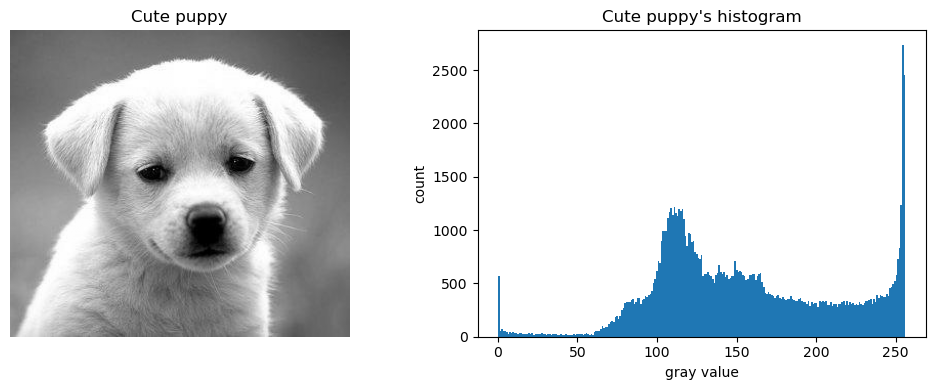

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].imshow(image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Cute puppy')

axs[1].hist(image.ravel(), bins=255, range=[0,256])
axs[1].set_xlabel('gray value')
axs[1].set_ylabel('count')
axs[1].set_title('Cute puppy\'s histogram')

plt.tight_layout()
plt.show()

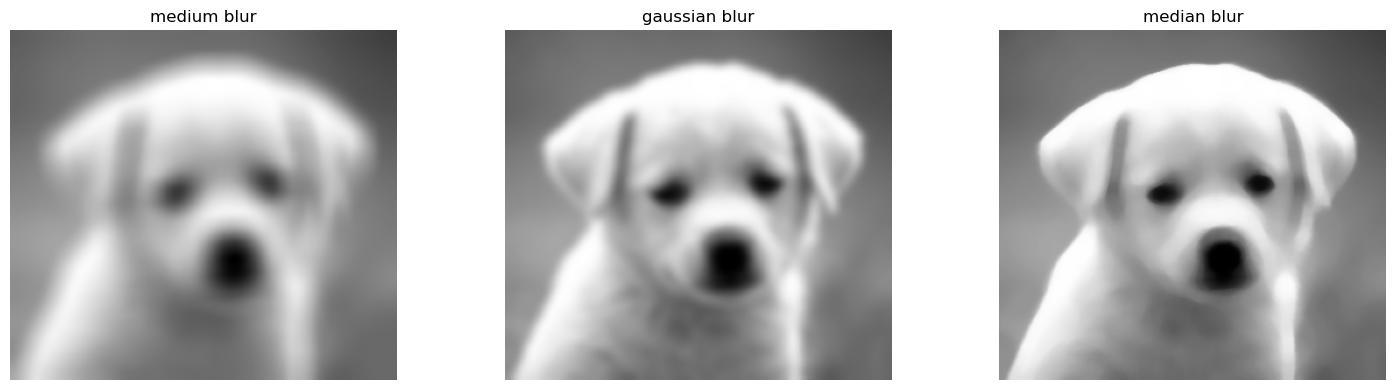

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))

img_blur_medium = cv2.blur(image, (25,25))
img_blur_gaussian = cv2.GaussianBlur(image, (15,15), 4)
img_blur_median = cv2.medianBlur(image, 15)

axs[0].imshow(img_blur_medium, cmap='gray')
axs[0].set_title('medium blur')
axs[0].axis('off')

axs[1].imshow(img_blur_gaussian, cmap='gray')
axs[1].set_title('gaussian blur')
axs[1].axis('off')

axs[2].imshow(img_blur_median, cmap='gray')
axs[2].set_title('median blur')
axs[2].axis('off')

plt.tight_layout()
plt.show()

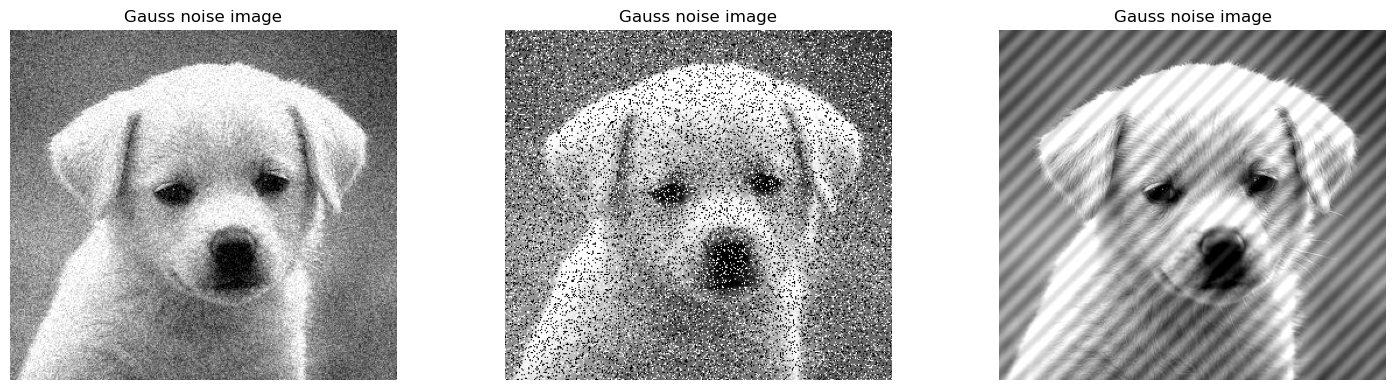

In [4]:
# Apply gauss noise
def gauss_noise(image, mean=0, std=25):
    gauss_noise  = np.random.normal(mean, std, image.shape)
    output = image + gauss_noise
    output = np.clip(output, 0, 255).astype(np.uint8)
    return output

def salt_pepper_noise(image, prob=0.25):
    output = np.copy(image)
    rdn = np.random.rand(*image.shape)
    output[rdn < prob/2] = 0
    output[rdn > 1 - (prob/2)] = 255
    return output

def periodic_noise(image, amplitude, fx=0.05, fy=0.05, phase=0):
    rows, cols = image.shape

    # Cordinate grid
    x = np.arange(cols)
    y = np.arange(rows)
    X, Y = np.meshgrid(x, y)

    noise = amplitude * np.sin(2 * np.pi * (fx * X + fy * Y) + phase)

    output = image + noise 
    output = np.clip(output, 0, 255).astype(np.uint8)

    return output
    
gauss_noise_img = gauss_noise(image)
salt_pepper_image = salt_pepper_noise(image, prob=0.25)
periodic_noise_img = periodic_noise(image,30)

fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].imshow(gauss_noise_img, cmap='gray')
axs[0].set_title('Gauss noise image')
axs[0].axis('off')

axs[1].imshow(salt_pepper_image, cmap='gray')
axs[1].set_title('Gauss noise image')
axs[1].axis('off')

axs[2].imshow(periodic_noise_img, cmap='gray')
axs[2].set_title('Gauss noise image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

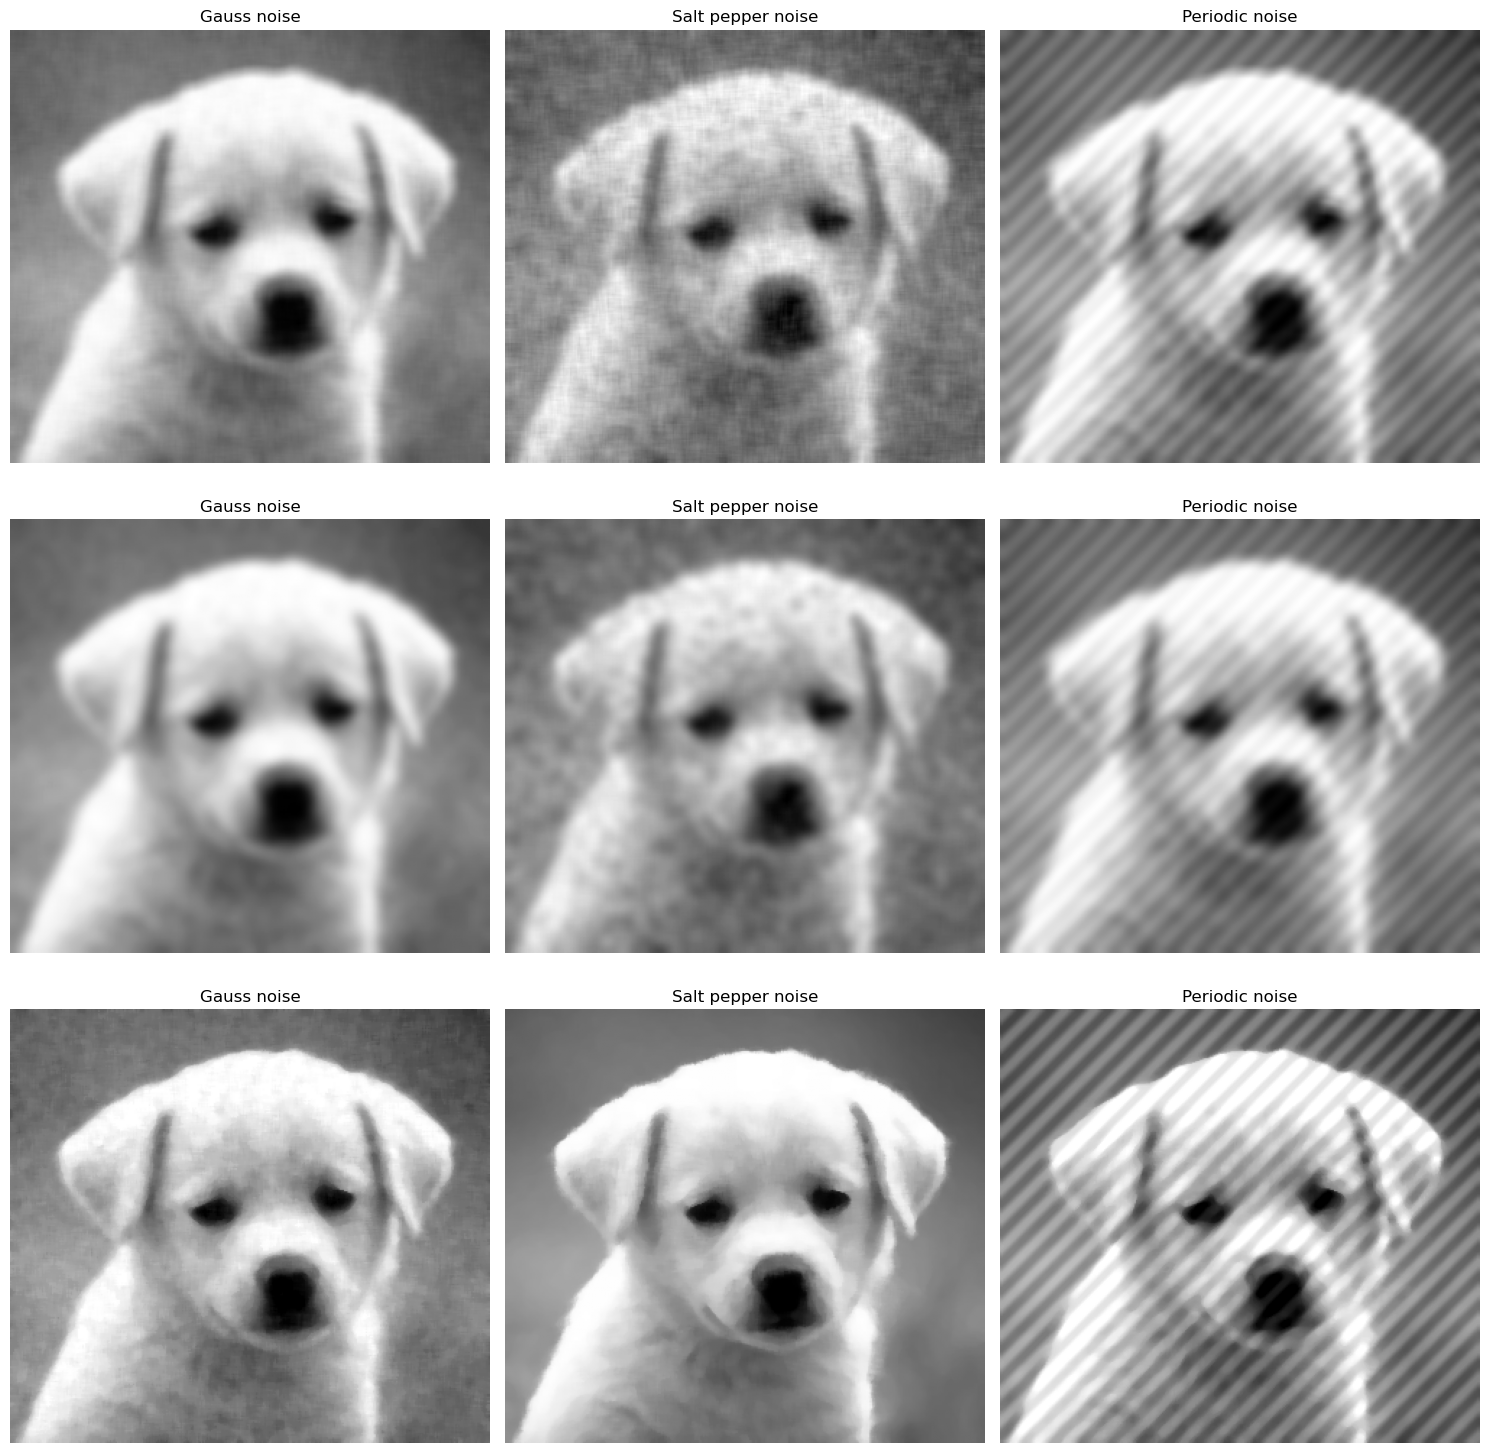

In [32]:
name_noise = ['Gauss noise', 'Salt pepper noise', 'Periodic noise']
name_blur = ['Medium blur', 'Gauss blur', 'Median blur']
noise_image = [gauss_noise_img, salt_pepper_image, periodic_noise_img]
img_process = [[None for _ in range(len(name_blur))] for _ in range(len(name_noise))]

fig, axs = plt.subplots(3, 3, figsize=(15,15))

for i in range(len(name_noise)):
    for j in range(len(name_blur)):
        if i == 0:
            img_process[i][j] = cv2.blur(noise_image[j], (10,10))
        if i == 1:
            img_process[i][j] = cv2.GaussianBlur(noise_image[j], (15,15), 4)
        if i == 2:
            img_process[i][j] = cv2.medianBlur(noise_image[j],7)

# Display the image
for i, blur in enumerate(name_blur):
    for j, noise in enumerate(name_noise):
        axs[i][j].imshow(img_process[i][j], cmap='gray')
        axs[i][j].set_title(noise)
        axs[i][j].axis('off')

plt.tight_layout()
plt.show()

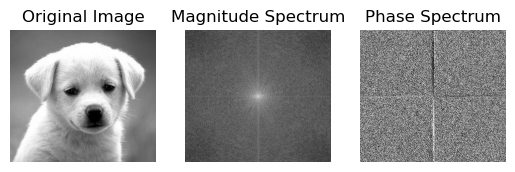

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image and convert to grayscale
img = cv2.imread('B2DBy.jpg', 0)

# Apply 2D DFT
dft = np.fft.fft2(img)
dft_shifted = np.fft.fftshift(dft)

# Compute magnitude and phase
magnitude = np.abs(dft_shifted)
phase = np.angle(dft_shifted)

# Log scale magnitude for visualization
log_magnitude = np.log(1 + magnitude)

# Display
plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray'), plt.title('Original Image'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(log_magnitude, cmap='gray'), plt.title('Magnitude Spectrum'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(phase, cmap='gray'), plt.title('Phase Spectrum'), plt.axis('off')
plt.show()


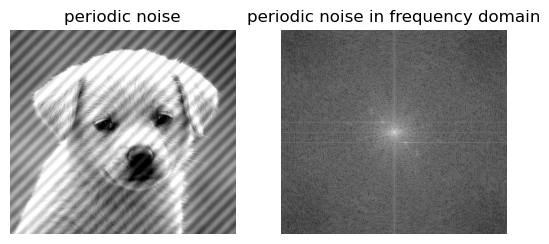

In [8]:
# Transform periodic noise image in spatial domain into frequency domain
puppy_dft = np.fft.fft2(periodic_noise_img)
puppy_dft_shift = np.fft.fftshift(puppy_dft)

puppy_magnitude = np.abs(puppy_dft_shift)
log_puppy_magnitude = 20 * np.log(1 + puppy_magnitude)

plt.subplot(1,2,1), plt.imshow(periodic_noise_img, cmap='gray'), plt.axis('off'), plt.title('periodic noise')
plt.subplot(1,2,2), plt.imshow(log_puppy_magnitude, cmap='gray'), plt.axis('off'), plt.title('periodic noise in frequency domain')

plt.show()

In [15]:
# Apply ideal, butterworth, gaussian lowpass filtering to remove the noise

# Ideal low pass filter
def ideal_low_pass(image, cutoff):
    rows, cols = image.shape
    crows, ccols = rows//2, cols//2
    mask = np.zeros((rows, cols), np.uint8)
    for u in range(rows):
        for v in range(cols):
            if np.sqrt((u - crows)**2 + (v - ccols)**2) <= cutoff:
                mask[u, v] = 1
    return mask

# Butterworth low pass filter
def butterworth_low_pass(image, cutoff, order):
    rows, cols = image.shape
    crows, ccols = rows // 2, cols // 2
    u = np.arange(rows)
    v = np.arange(cols)
    U, V = np.meshgrid(u - crows, v - ccols, indexing='ij')
    D = np.sqrt(U**2 + V**2)
    mask = 1 / (1 + (D / cutoff)**(2 * order))
    return mask.astype(np.float32)

#  Gaussian low pass image
def gaussian_low_pass(image, cutoff):
    rows, cols = image.shape
    crows, ccols = rows//2, cols//2
    u = np.arange(rows)
    v = np.arange(cols)
    U, V = np.meshgrid(u - crows, v - ccols, indexing='ij')
    D = np.sqrt(U**2 + V**2)
    mask = np.exp((-1 * D**2) / (2 * cutoff**2))
    return mask.astype(np.float32)

In [16]:
ideal_mask = ideal_low_pass(image, 50)
butterworth_mask = butterworth_low_pass(image, 50, 2)
gaussian_mask = gaussian_low_pass(image, 50)

ideal_freq = puppy_dft_shift * ideal_mask
butterworth_freq = puppy_dft_shift * butterworth_mask
gaussian_freq = puppy_dft_shift * gaussian_mask

# Transform frequency domain back to spatial domian
ideal_img = np.abs(np.fft.ifft2(np.fft.ifftshift(ideal_freq)))
butterworth_img = np.abs(np.fft.ifft2(np.fft.ifftshift(butterworth_freq)))
gaussian_img = np.abs(np.fft.ifft2(np.fft.ifftshift(gaussian_freq)))

